In [2]:
import os
import mne
import pprint
import numpy as np
from matplotlib.pyplot import plot

import brainflow
from brainflow.board_shim import BoardIds, BrainFlowInputParams, BoardShim
from brainflow.data_filter import DataFilter

In [3]:
# board setup

# OpenBCI Cyton board
cyton_board_ID = 0
print("\n" + str(BoardIds(cyton_board_ID))) 

# serial connection
serial_port = 'COM3'
params = BrainFlowInputParams()
params.serial_port = serial_port

# create board
board = BoardShim(board_id=cyton_board_ID, input_params=params)

# board attributes
board_name = board.get_device_name(board_id=board.board_id)
channel_names = board.get_eeg_names(board_id=board.board_id)
samp_freq = board.get_sampling_rate(board_id=board.board_id)  # 250 Hz
eeg_channel_idx = board.get_eeg_channels(board_id=board.board_id)  # EEG channel indices (1-8)


BoardIds.CYTON_BOARD


In [4]:
# load and format data

# main directory
main_dir = os.getcwd()

# eeg data directory
eeg_dir = os.path.join(main_dir, "raw_eeg_data")

# read data from saved file
filename = "1621427011.6632674.csv"
filepath = os.path.join(eeg_dir, filename)

all_raw_data = np.loadtxt(filepath, delimiter=',')
print(np.shape(all_raw_data))
raw_eeg_data = np.transpose(all_raw_data[:, eeg_channel_idx])
print(np.shape(raw_eeg_data))

# create the info structure needed by MNE
info = mne.create_info(channel_names, samp_freq, ch_types='eeg')
# create Raw object
raw = mne.io.RawArray(raw_eeg_data, info)

(1421, 24)
(8, 1421)
Creating RawArray with float64 data, n_channels=8, n_times=1421
    Range : 0 ... 1420 =      0.000 ...     5.680 secs
Ready.


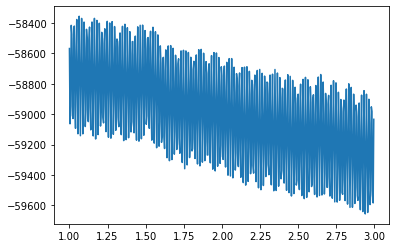

In [5]:
# single-channel test plot

start_stop_seconds = np.array([1, 3])
start_sample, stop_sample = (start_stop_seconds * samp_freq).astype(int)
channel_index = 3
raw_selection = raw[channel_index, start_sample:stop_sample]

x = raw_selection[1]
y = raw_selection[0].T
plot(x, y)

In [6]:
# plot eeg data

#raw.plot()
#raw.plot_psd()

In [7]:
notch_freqs = (60, 120)
raw_notched = raw.copy().notch_filter(freqs=notch_freqs)
#raw_notched.plot_psd()

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

<ipython-input-7-c234038ffb79>:2: RuntimeWarning: filter_length (1651) is longer than the signal (1421), distortion is likely. Reduce filter length or filter a longer signal.
  raw_notched = raw.copy().notch_filter(freqs=notch_freqs)


Effective window size : 5.684 (s)
<ipython-input-8-eb8ad2d3d13b>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = data.plot_psd(fmax=samp_freq/2, average=False)


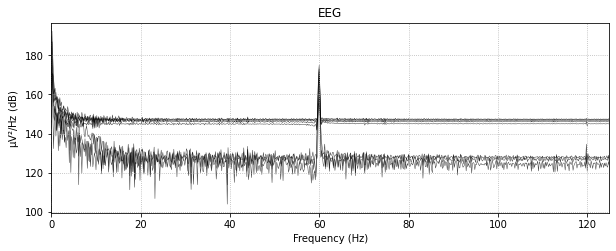

Effective window size : 5.684 (s)
<ipython-input-8-eb8ad2d3d13b>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = data.plot_psd(fmax=samp_freq/2, average=False)


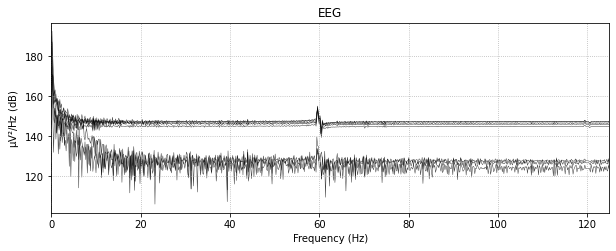

In [8]:
for title, data in zip(['Raw EEG', '60, 120 Hz Notched EEG'], [raw, raw_notched]):
    fig = data.plot_psd(fmax=samp_freq/2, average=False)
    fig.suptitle(title, size='xx-large', weight='bold')

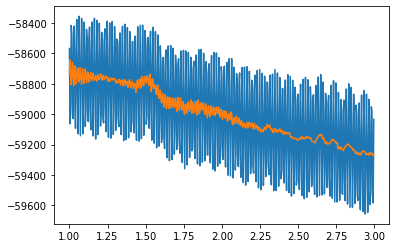

In [9]:
# single-channel test plot

start_stop_seconds = np.array([1, 3])
start_sample, stop_sample = (start_stop_seconds * samp_freq).astype(int)
channel_index = 3

# raw eeg
raw_selection = raw[channel_index, start_sample:stop_sample]
x = raw_selection[1]
y = raw_selection[0].T
plot(x, y)

# 60, 120 Hz notched eeg
raw_notched_selection = raw_notched[channel_index, start_sample:stop_sample]
x = raw_notched_selection[1]
y = raw_notched_selection[0].T
plot(x, y)

In [10]:
raw_resampled = mne.filter.resample(raw_eeg_data, down=samp_freq/128)